In [1]:
from cmocean.cm import thermal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mhkit import acoustics


P = acoustics.io.read_iclisten("data/acoustics/RBW_6661_20240601_053114.wav")
# P = acoustics.io.read_soundtrap("data/acoustics/6247.230204150508.wav", Sf=-177)


In [2]:
#acoustics.io.export_audio(P)

In [3]:
spsd = acoustics.sound_pressure_spectral_density(P, P.fs)
spsdl = acoustics.sound_pressure_spectral_density_level(spsd)

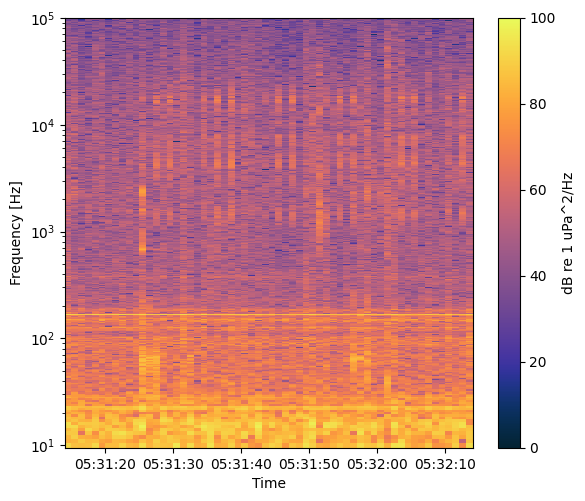

In [4]:
fmin = 10
fmax = 100000

# Create high res spectogram
fig, ax = acoustics.graphics.plot_spectogram(
    spsdl, fmin, fmax, kwargs={"cmap": thermal, "vmin": 0, "vmax": 100}
)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))


Text(0.5, 1.0, 'Median and Quantile Sound Pressure Spectral Density Level')

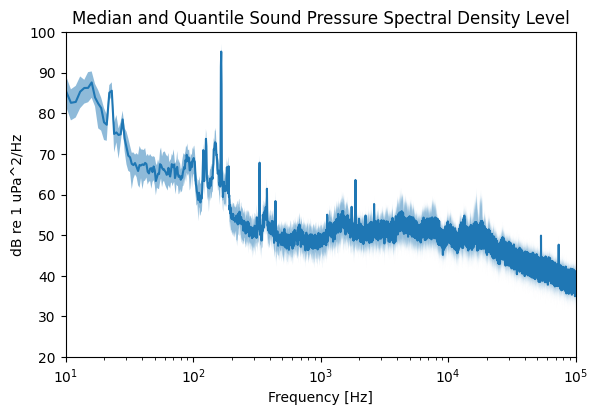

In [5]:
# Time average into 30 s windows
window = 30
spsdl_50 = acoustics.time_average(spsdl, window, method="median")
spsdl_25 = acoustics.time_average(spsdl, window, method="quantile", method_arg=0.25)
spsdl_75 = acoustics.time_average(spsdl, window, method="quantile", method_arg=0.75)

# Plot 30 s medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_50.mean("time_bins"), fmin, fmax)
ax.fill_between(spsdl_50["freq"], spsdl_25.mean("time_bins"), spsdl_75.mean("time_bins"), alpha=0.5, facecolor="C0", edgecolor=None)
ax.set_ylim(20, 100)
ax.set_title("Median and Quantile Sound Pressure Spectral Density Level")

Text(0.5, 1.0, 'Median and Quantile Third Octave Sound Pressure Spectral Density Level')

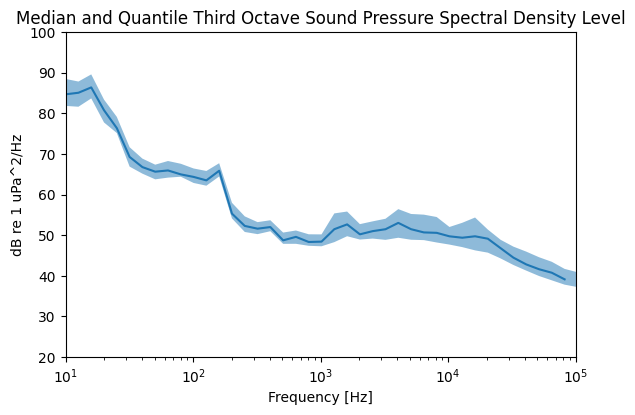

In [6]:

# Frequency average into # octave bands
octave = 3
spsdl_mean = acoustics.band_average(spsdl, octave, fmin, fmax)

# Time average into 30 s windows
window = 30
spsdl_50 = acoustics.time_average(spsdl_mean, window, method="median")
spsdl_25 = acoustics.time_average(spsdl_mean, window, method="quantile", method_arg=0.25)
spsdl_75 = acoustics.time_average(spsdl_mean, window, method="quantile", method_arg=0.75)

# Plot 30 s medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(spsdl_50.mean("time_bins"), fmin, fmax)
ax.fill_between(spsdl_50["freq_bins"], spsdl_25.mean("time_bins"), spsdl_75.mean("time_bins"), alpha=0.5, facecolor="C0", edgecolor=None)
ax.set_ylim(20, 100)
ax.set_title("Median and Quantile Third Octave Sound Pressure Spectral Density Level")


spl_median: 103.45961693711234


Text(0.5, 1.0, 'Median and Quantile Third Octave Sound Pressure Level')

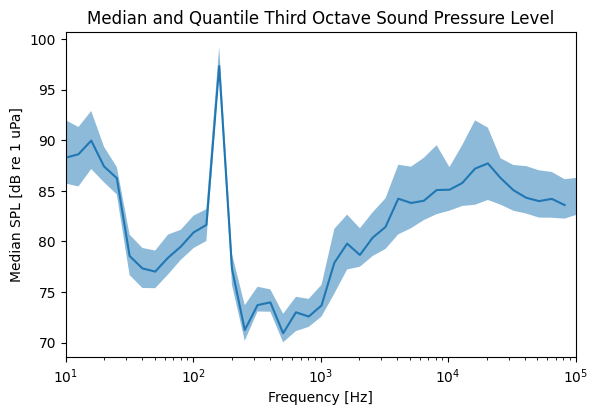

In [17]:
# Sound pressure level
spl = acoustics.sound_pressure_level(spsd, fmin, fmax)
spl_50 = acoustics.time_average(spl, window, method="median")
print(f"spl_median: {spl_50.mean().values}")

# Median Third octave sound pressure level (also interquartile)
tospl = acoustics.third_octave_sound_pressure_level(spsd, fmin, fmax)

# Time average into 30 s windows
window = 30
tospl_50 = acoustics.time_average(tospl, window, method="median")
tospl_25 = acoustics.time_average(tospl, window, method="quantile", method_arg=0.25)
tospl_75 = acoustics.time_average(tospl, window, method="quantile", method_arg=0.75)

# Plot 30 s medians and quantiles
fig, ax = acoustics.graphics.plot_spectra(tospl_50.mean("time_bins"), fmin, fmax)
ax.fill_between(tospl_50["freq_bins"], tospl_25.mean("time_bins"), tospl_75.mean("time_bins"), alpha=0.5, facecolor="C0", edgecolor=None)
ax.set(xlabel="Frequency [Hz]", ylabel="Median SPL [dB re 1 uPa]")
ax.set_title("Median and Quantile Third Octave Sound Pressure Level")

In [9]:
### Import NOAA wind and wave statistics
### Create SPL wave stat matrix figure